In [9]:
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets_utils import ds_load
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## Dataset loading

In [2]:
DATASETS_PATH = Path('datasets')

In [3]:
ds_name = 'ArticularyWordRecognition'
train_ds, test_ds = ds_load(DATASETS_PATH, ds_name, scaler=StandardScaler())

experiment_name = f'{ds_name}/TestExperimentScaling'

In [4]:
directory = f'experiments/{experiment_name}/protos/epoch-200'
file_pattern = re.compile(r'prototype-ts-original\d+\.npy')

files = [os.path.join(directory, f) for f in os.listdir(directory) if file_pattern.match(f)]

protos = [np.load(file).transpose()[np.newaxis, ...] for file in files]
protos = np.unique(protos, axis=0)
protos = np.vstack(protos)

mask = np.isin(train_ds.X, protos).all(axis=(1, 2))

In [5]:
def tsne_train_test(train_X, test_X):
    tsne = TSNE(perplexity=30)
    combined_X = np.concatenate([train_X, test_X], axis=0)
    transformed_X = tsne.fit_transform(combined_X.reshape(combined_X.shape[0], -1))
    return transformed_X[:train_X.shape[0]], transformed_X[train_X.shape[0]:]

## Visualization in the input space

In [68]:
new_train_X, new_test_X = tsne_train_test(train_ds.X, test_ds.X)

### Train set

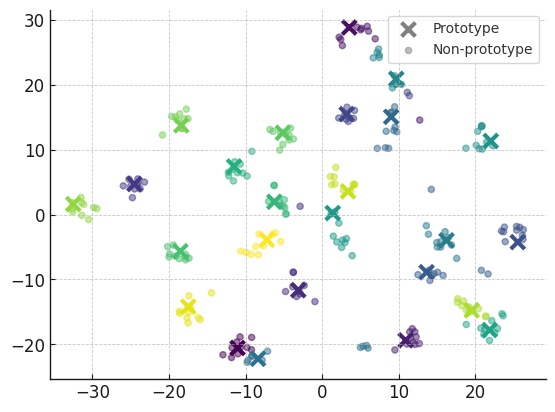

In [69]:
plt.scatter(new_train_X[~mask, 0], new_train_X[~mask, 1], c=train_ds.y[~mask], marker='o', alpha=0.5, s=20)
plt.scatter(new_train_X[mask, 0], new_train_X[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)

prototype_legend = plt.scatter([], [], marker='x', color='gray', label='Prototype', s=100, lw=3, facecolors='gray')
non_prototype_legend = plt.scatter([], [], marker='o', color='gray', label='Non-prototype', alpha=0.5, s=20, edgecolors='gray')

plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')

### Test set

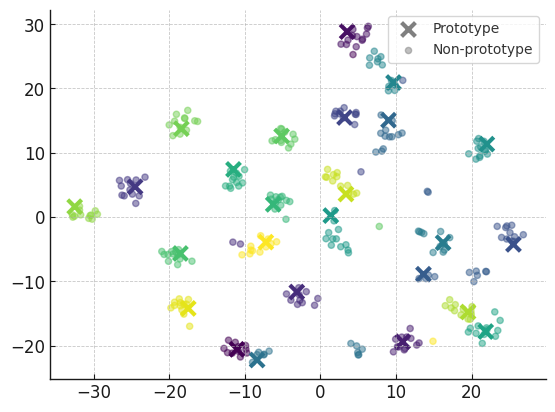

In [70]:
plt.scatter(new_test_X[:, 0], new_test_X[:, 1], c=test_ds.y, marker='o', alpha=0.5, s=20)
plt.scatter(new_train_X[mask, 0], new_train_X[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)
plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')

## Visualization in the latent space

In [44]:
model_path = f'experiments/{experiment_name}/models/last-epoch.pth'
ptsnet = torch.load(model_path, map_location=torch.device('cpu'))
encoded_train = ptsnet.conv_features(torch.tensor(train_ds.X)).numpy()
encoded_test = ptsnet.conv_features(torch.tensor(test_ds.X)).numpy()

In [45]:
new_encoded_train, new_encoded_test = tsne_train_test(encoded_train, encoded_test)

### Train set

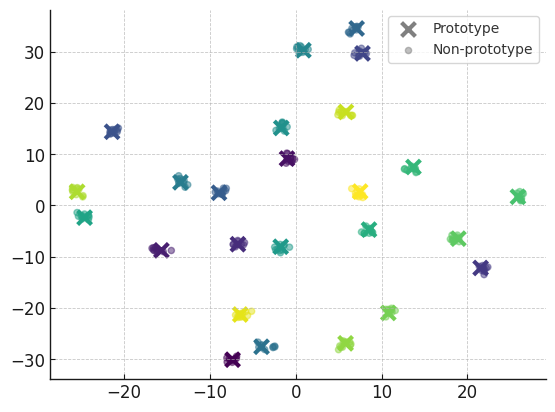

In [46]:
plt.scatter(new_encoded_train[~mask, 0], new_encoded_train[~mask, 1], c=train_ds.y[~mask], marker='o', alpha=0.5, s=20)
plt.scatter(new_encoded_train[mask, 0], new_encoded_train[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)
plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')

### Test set

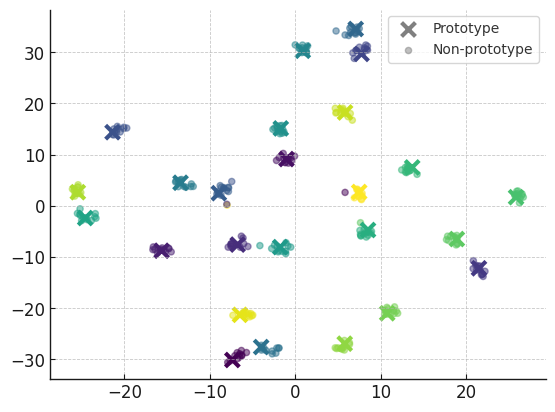

In [47]:
plt.scatter(new_encoded_test[:, 0], new_encoded_test[:, 1], c=test_ds.y, marker='o', alpha=0.5, s=20)
plt.scatter(new_encoded_train[mask, 0], new_encoded_train[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)
plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')

## Visualization based on distances to prototypes

In [51]:
model_path = f'experiments/{experiment_name}/models/last-epoch.pth'
ptsnet = torch.load(model_path, map_location=torch.device('cpu'))
print(train_ds.X.shape)
distances_train = ptsnet.prototype_distances(torch.tensor(train_ds.X)).numpy()
distances_test = ptsnet.prototype_distances(torch.tensor(test_ds.X)).numpy()
print(distances_train.shape)

(275, 9, 144)
(275, 250, 1)


In [56]:
enc_distances_train, enc_distances_test = tsne_train_test(distances_train, distances_test)

### Train set

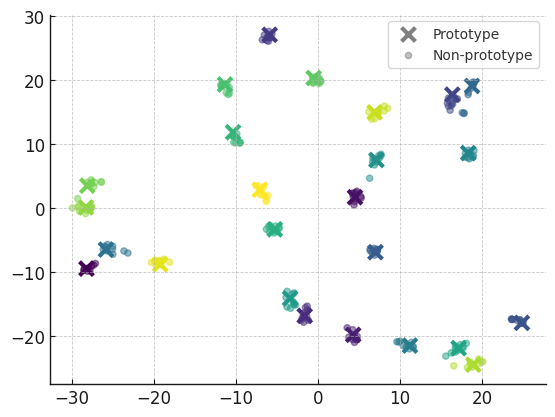

In [57]:
plt.scatter(enc_distances_train[~mask, 0], enc_distances_train[~mask, 1], c=train_ds.y[~mask], marker='o', alpha=0.5, s=20)
plt.scatter(enc_distances_train[mask, 0], enc_distances_train[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)
plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')

### Test set

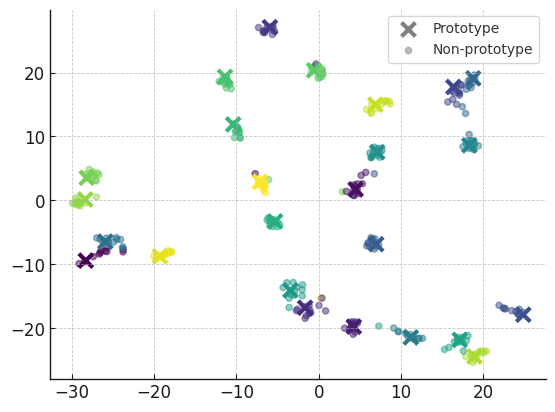

In [58]:
plt.scatter(enc_distances_test[:, 0], enc_distances_test[:, 1], c=test_ds.y, marker='o', alpha=0.5, s=20)
plt.scatter(enc_distances_train[mask, 0], enc_distances_train[mask, 1], c=train_ds.y[mask], marker='x', s=100, lw=3)
plt.legend(handles=[prototype_legend, non_prototype_legend], loc='upper right')